In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
combined_data = pd.read_csv('./data/Real_combine.csv')

In [24]:
combined_data.head()
combinded_data=combined_data.dropna()

In [25]:
combined_data.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    1
dtype: int64

In [26]:
# Extracting Dependent and independent variables
X = combined_data.iloc[:, :-1]
y = combined_data.iloc[:, -1]

In [27]:

# Splitting the data set into train and test int the 33% of test size
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [28]:
# Using XGboost Regresser model as it is an continous variable problem
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBoostError: [09:35:58] ..\src\data\data.cc:367: Check failed: valid: Label contains NaN, infinity or a value too large.

In [ ]:
f'Coefficient of determination R^2 on train set {xgb.score(X_train, y_train)}'

'Coefficient of determination R^2 on train set 0.9998960764246853'

In [ ]:
f'Coefficient of determination R^2 on test set {xgb.score(X_test, y_test)}'

'Coefficient of determination R^2 on test set 0.30729228385164586'

In [ ]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(xgb, X, y, cv = 5)

In [ ]:
score

array([ 0.24462085,  0.10046648, -0.2286391 , -0.18570535,  0.29973477])

In [ ]:
pred = xgb.predict(X_test)

C:\Users\deepa\anaconda3\envs\ML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PM_2_5', ylabel='Density'>

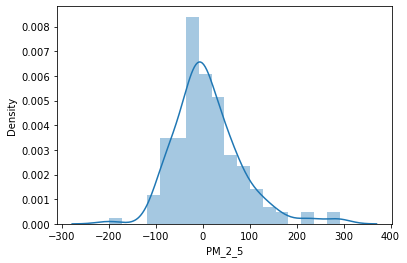

In [ ]:
sns.distplot(y_test - pred)

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=1200, num=12)]
learning_rate = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
max_depth = [int(x) for x in np.linspace(5, 30, num=6)]
subsample = [0.7, 0.6, 0.8]
min_child_weight = list(range(3, 8))
objective = ['reg:squarederror']
params = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'max_depth': max_depth,
    'subsample': subsample,
    'min_child_weight': min_child_weight,
    'objective': objective
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
search = RandomizedSearchCV(xgb, params, scoring='neg_mean_squared_error', 
                            cv=5, n_iter=100, random_state=43, n_jobs=-1, verbose=True)
search.fit(X,y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[10:23:28] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          enable_categorical=False, gamma=0,
                                          gpu_id=-1, importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=5,
                                          min_child_weight=1,
                                          min_samples_leaf=5, missing=nan,
                                          monotone_constrai...
                                          verbosity=None),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learni

In [ ]:
search.best_params_

{'subsample': 0.8,
 'objective': 'reg:squarederror',
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 20,
 'learning_rate': 0.05}

C:\Users\deepa\anaconda3\envs\ML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PM_2_5', ylabel='Density'>

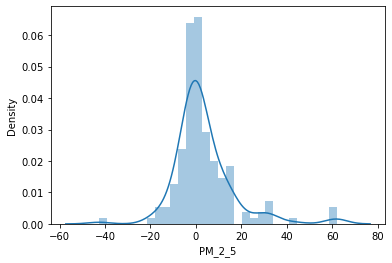

In [ ]:
pred = search.predict(X_test)
sns.distplot(y_test-pred)

In [ ]:
from sklearn import metrics
print(f"Mean Abs Error: {metrics.mean_absolute_error(y_test, pred)}")
print(f"Mean Sq Error: {metrics.mean_squared_error(y_test, pred)}")
print(f"Root Mean Error: {np.sqrt(metrics.mean_squared_error(y_test, pred))}")

Mean Abs Error: 8.277064572150065
Mean Sq Error: 192.08441564842266
Root Mean Error: 13.859452213144019


In [ ]:
import pickle
pickle.dump(search, open('xgb.pkl', 'wb'))